In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats as bs
import two_dimensional_analysis as td

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats
%aimport two_dimensional_analysis

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_base/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [ ]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'base', 'ambient_swapped', 'higher_conv_level', 
    'four_levels', 'no_steiner', 'lower_ref_thresh',
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

tracks_dir = [
    'base', 'lower_conv_level', 'higher_conv_level', 
    'four_levels', 'no_steiner', 'lower_ref_thresh',
    'base', 'base', 
    'base', 'base', 'base', 
    'base', 'base', 'base', 'combined']

[
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15] = [
    copy.deepcopy(class_thresh_base) for i in range(4)]

class_thresh_S4['SHEAR_MAG'] = 4
class_thresh_RV4['REL_VEL_MAG'] = 4
class_thresh_T15['ANGLE_BUFFER'] = 15
class_thresh_SO15['OFFSET_MAG'] = 15000

class_thresh_comb = {
    'OFFSET_MAG': 12500,
    'SHEAR_MAG': 3,
    'VEL_MAG': 5,
    'REL_VEL_MAG': 3,
    'ANGLE_BUFFER': 15}

class_threshes = [
    None, None, None, 
    None, None, None,
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15, None, 
    None, None, None,
    class_thresh_comb]

[
    excl_thresh_B05, excl_thresh_A2000, 
    excl_thresh_L50, excl_thresh_L25] = [
    copy.deepcopy(excl_thresh_base) for i in range(4)]

excl_thresh_B05['BORD_THRESH'] = 0.0005
excl_thresh_A2000['SMALL_AREA'] = 2000
excl_thresh_L50['MAJOR_AXIS_LENGTH'] = 50
excl_thresh_L25['MAJOR_AXIS_LENGTH'] = 25

excl_thresh_comb = {
    'SMALL_AREA': 2000,
    'LARGE_AREA': 50000,
    'BORD_THRESH': 0.001,
    'MAJOR_AXIS_LENGTH': 25,
    'AXIS_RATIO': 2,
    'DURATION': 30}

excl_threshes = [
    None, None, None, 
    None, None, None,
    None, None,
    None, None, excl_thresh_B05, 
    excl_thresh_A2000, excl_thresh_L50, excl_thresh_L25,
    excl_thresh_comb]

non_linear_conds = [
    False, False, False, False, False, False, False, False,
    False, False, False, False, True, True, False]

# Generate Figures

In [ ]:
all_ACCESS = bs.get_all_and_QC_ACCESS_stats(save_dir)
all_radar = bs.get_all_and_QC_radar_stats(save_dir)
time_series_all = bs.get_all_time_series(save_dir)

In [4]:
[
    all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
    all_obs_active_radar, QC_obs_active_radar] = all_radar

[
    all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
    all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

[
    time_series_radar, time_series_weak_radar, time_series_active_radar,
    time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS] = time_series_all

In [49]:
radars = [42]
suff = 'test'
morning_only = False

In [20]:
suff = 'morning_only'

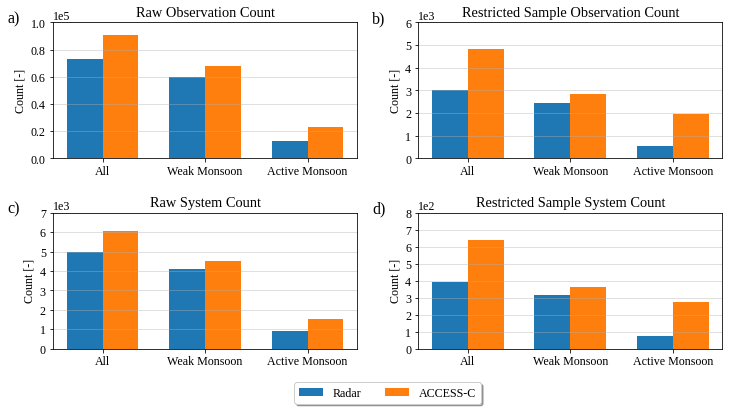

In [26]:
bs.plot_counts(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS)
plt.savefig(
    fig_dir + 'totals_ACCESS_radar_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

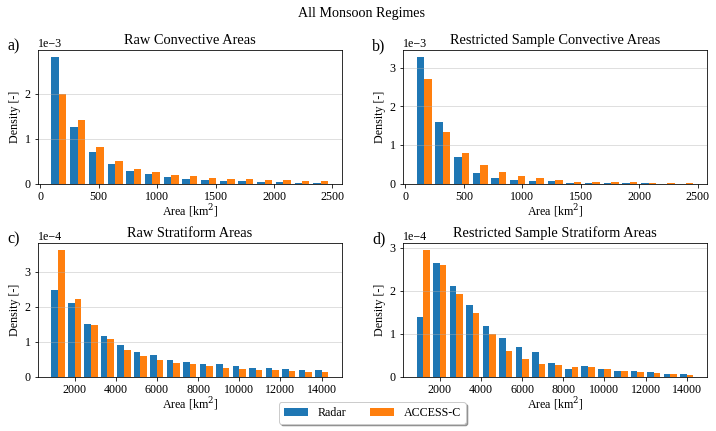

In [27]:
bs.compare_sizes(
    all_obs_radar, all_obs_ACCESS, 
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

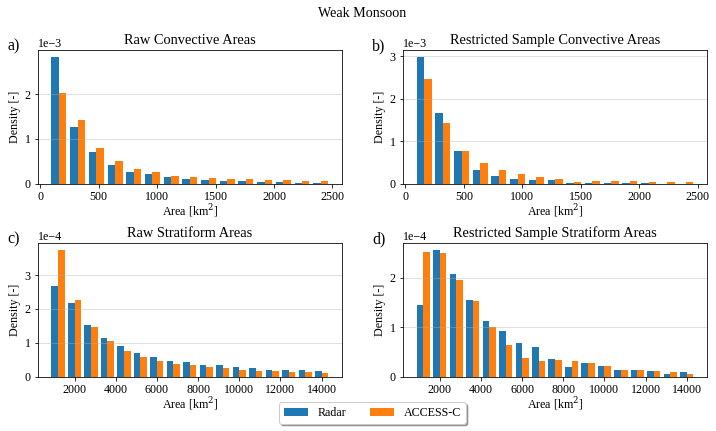

In [28]:
bs.compare_sizes(
    all_obs_weak_radar, all_obs_weak_ACCESS, 
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density,
    title='Weak Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

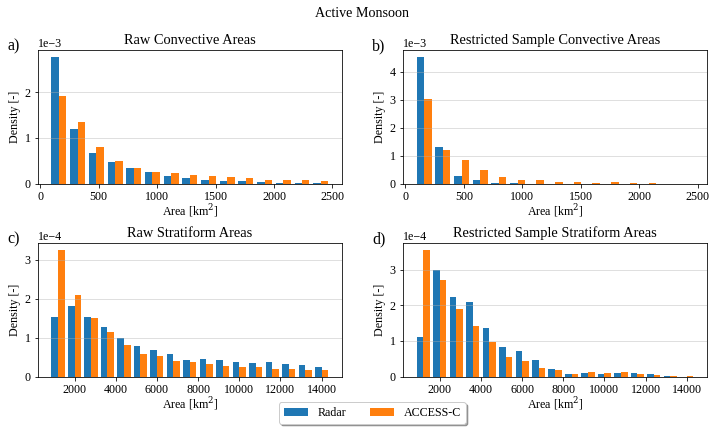

In [29]:
bs.compare_sizes(
    all_obs_active_radar, all_obs_active_ACCESS, 
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density,
    title='Active Monsoon')
plt.savefig(
    fig_dir + 'sizes_ACCESS_radar_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

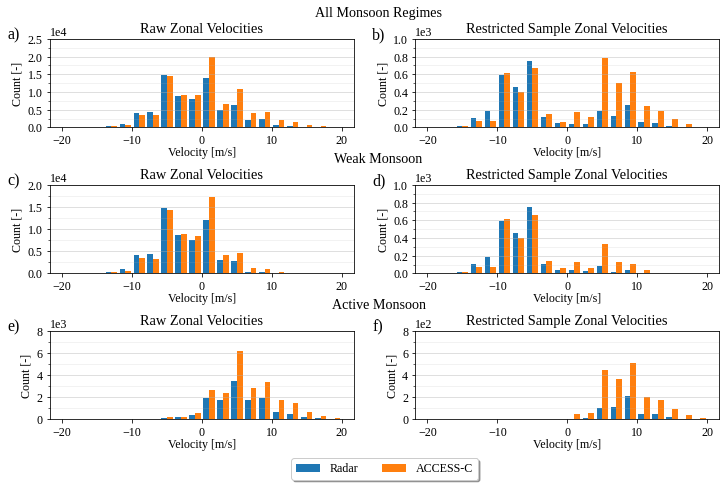

In [30]:
density=False

fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.compare_velocities(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', labels=False,
    legend=False, fig=fig, ax=axes[0,:])

bs.compare_velocities(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, labels=False,
    title='Weak Monsoon', legend=False, fig=fig, ax=axes[1,:])

bs.compare_velocities(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    labels=False, title='Active Monsoon', fig=fig, ax=axes[2,:])

plt.subplots_adjust(hspace=.65)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.75),
    ncol=2, fancybox=True, shadow=True)

maximums = [2.5e4, 10e2, 2e4, 10e2, 8e3, 8e2]
dy = [.5e4, 2e2, .5e4, 2e2, 2e3, 2e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')
    
plt.savefig(
    fig_dir + '/zonal_ACCESS_radar_active_compare_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

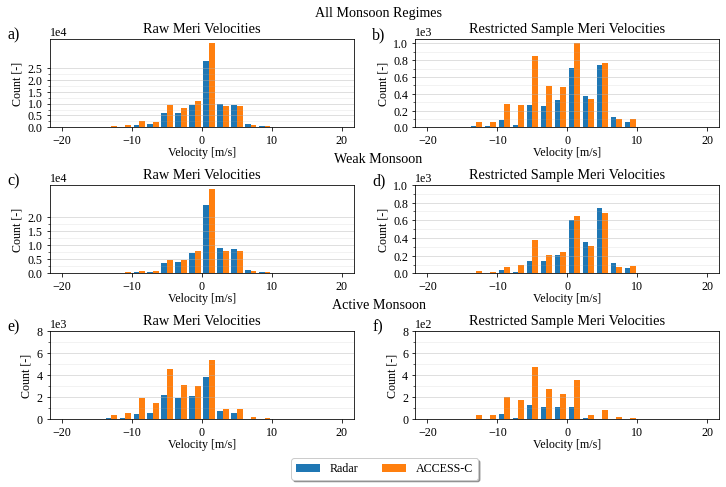

In [42]:
density=False

fig, axes = plt.subplots(3, 2, figsize=(12, 7))

direction='Meri'

bs.compare_velocities(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', labels=False,
    legend=False, fig=fig, ax=axes[0,:], direction=direction)

bs.compare_velocities(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, labels=False,
    title='Weak Monsoon', legend=False, fig=fig, ax=axes[1,:], direction=direction)

bs.compare_velocities(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    labels=False, title='Active Monsoon', fig=fig, ax=axes[2,:], direction=direction)

plt.subplots_adjust(hspace=.65)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.75),
    ncol=2, fancybox=True, shadow=True)

maximums = [2.5e4, 10e2, 2e4, 10e2, 8e3, 8e2]
dy = [.5e4, 2e2, .5e4, 2e2, 2e3, 2e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')
    
plt.savefig(
    fig_dir + '/meridional_ACCESS_radar_active_compare_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

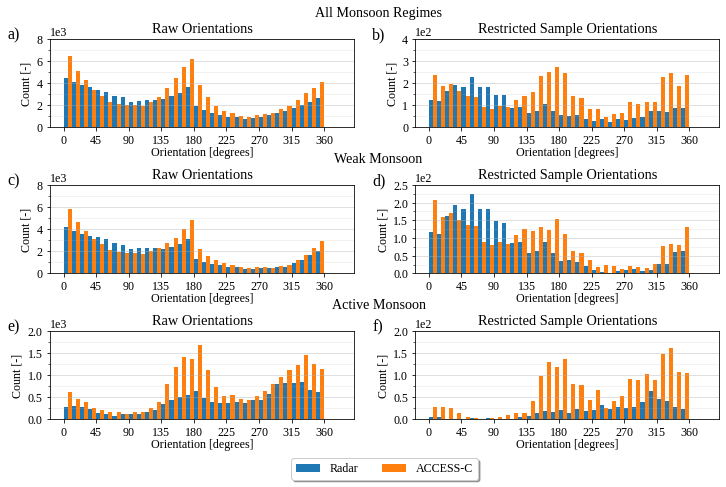

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.compare_orientation(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', fig=fig, ax=axes[0,:])

bs.compare_orientation(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon', fig=fig, ax=axes[1,:])

bs.compare_orientation(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon', fig=fig, ax=axes[2,:])

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.75),
    ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.65)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

maximums = [8e3, 4e2, 8e3, 2.5e2, 2e3, 2e2]
dy = [2e3, 1e2, 2e3, .5e2, .5e3, .5e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')

plt.savefig(
    fig_dir + '/orientation_ACCESS_radar_active_compare_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

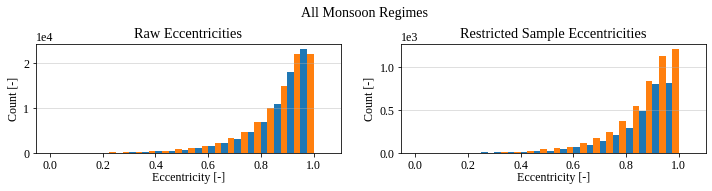

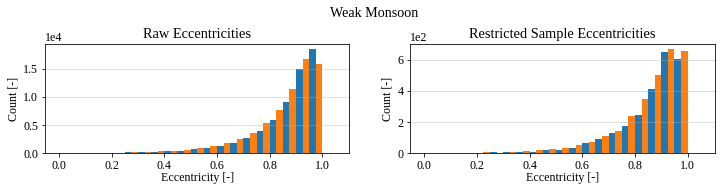

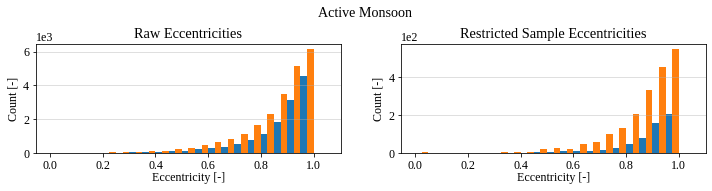

In [33]:
bs.compare_eccentricity(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_all_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_eccentricity(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

bs.compare_eccentricity(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'shape_ACCESS_radar_active_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

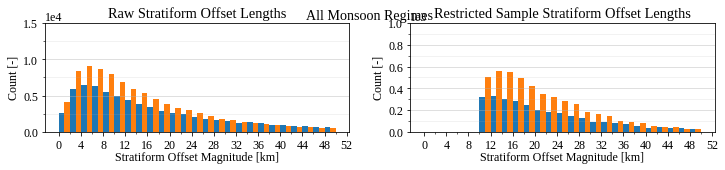

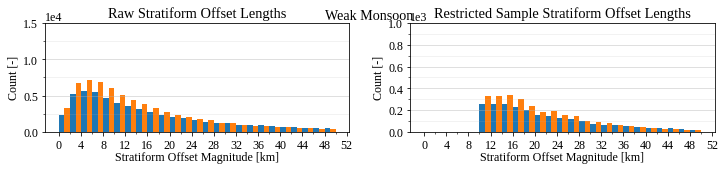

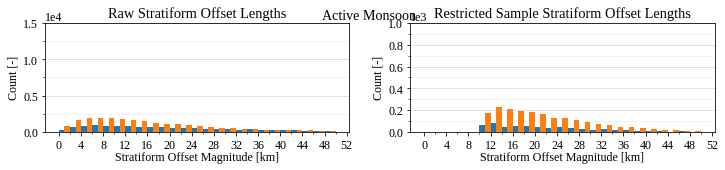

In [34]:
density = True

bs.compare_offset(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_weak_{}.png'.format(suff), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_offset(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon')

plt.savefig(
    fig_dir + 'offset_ACCESS_radar_active_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

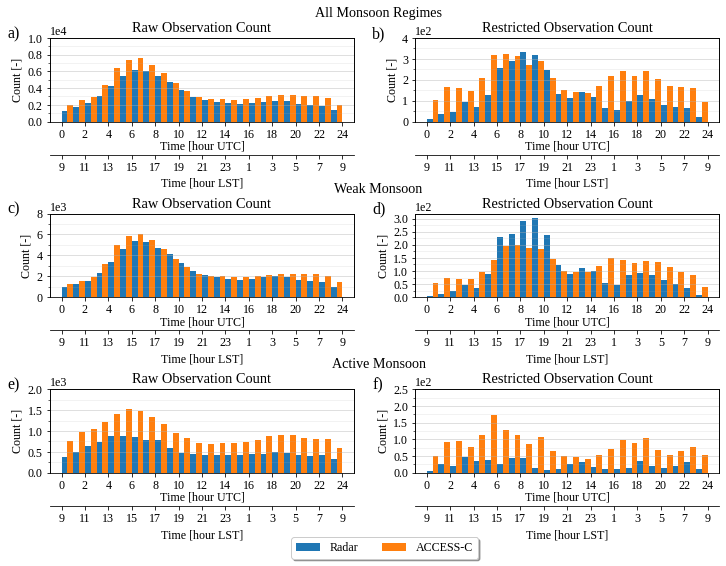

In [35]:
density=False

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

bs.compare_time(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    title='All Monsoon Regimes', fig=fig, ax=axes[0,:])

# plt.savefig(
#     fig_dir + 'time_ACCESS_radar_all_{}.png'.format(suff), dpi=200, 
#     facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=density, 
    title='Weak Monsoon', fig=fig, ax=axes[1,:])

# plt.savefig(
#     fig_dir + 'time_ACCESS_radar_weak_{}.png'.format(suff), 
#     dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

bs.compare_time(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=density, 
    title='Active Monsoon', fig=fig, ax=axes[2,:])

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -1.10),
    ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=1.1)

cl.make_subplot_labels(axes.flatten(), x_shift=-.14)

maximums = [10e3, 4e2, 8e3, 3e2, 2e3, 2.5e2]
dy = [2e3, 1e2, 2e3, .5e2, .5e3, .5e2]

for i in range(len(axes.flatten())):
    axes.flatten()[i].set_yticks(np.arange(0, maximums[i]+dy[i], dy[i]))
    axes.flatten()[i].set_yticks(
        np.arange(0, maximums[i]+dy[i]/2, dy[i]/2), minor=True)
    axes.flatten()[i].grid(which='minor', alpha=0.2, axis='y')
    axes.flatten()[i].grid(which='major', alpha=0.5, axis='y')

plt.savefig(
    fig_dir + '/time_ACCESS_radar_active_compare_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

In [36]:
(np.arange(0,25,1)+9) % 24

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9])

(array([[0.        , 0.        , 0.        , 0.01398964, 0.01243523,
         0.00829016, 0.01295337, 0.00725389, 0.00932642, 0.00518135,
         0.00492228, 0.00388601, 0.00181347, 0.00310881, 0.00207254,
         0.00259067, 0.0015544 , 0.00181347, 0.00207254, 0.00181347,
         0.00103627, 0.00103627, 0.00025907, 0.00025907, 0.        ,
         0.0007772 , 0.00051813, 0.0007772 , 0.00025907],
        [0.        , 0.        , 0.        , 0.02015873, 0.01142857,
         0.01349206, 0.00761905, 0.00714286, 0.0052381 , 0.00460317,
         0.0068254 , 0.00301587, 0.00269841, 0.00253968, 0.00253968,
         0.00253968, 0.00190476, 0.00142857, 0.0015873 , 0.00063492,
         0.00047619, 0.00047619, 0.00015873, 0.00047619, 0.00047619,
         0.00079365, 0.00031746, 0.00047619, 0.00095238]]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290]),
 <a list of 2 Ba

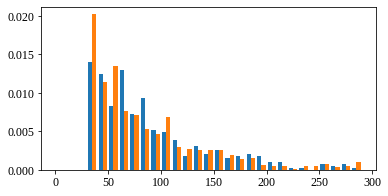

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.hist([QC_obs_radar[-1], QC_obs_ACCESS[-1]], bins=np.arange(0,300,10), density=True)

In [5]:
all_obs_regional = bs.get_all_regional(save_dir)
[
    all_obs_ACCESS_42, QC_obs_ACCESS_42, all_obs_ACCESS_63, QC_obs_ACCESS_63,
    all_obs_ACCESS_77, QC_obs_ACCESS_77, all_obs_radar_42, QC_obs_radar_42,
    all_obs_radar_63, QC_obs_radar_63, all_obs_radar_77, QC_obs_radar_77] = all_obs_regional

SyntaxError: invalid syntax (147721765.py, line 1)

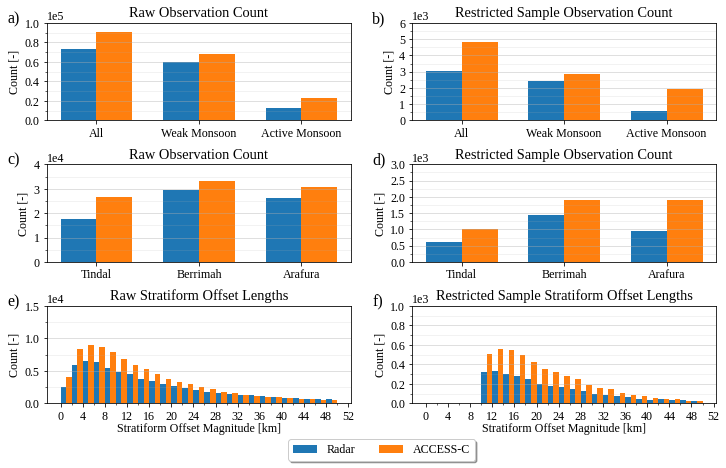

In [40]:
density = False

fig, axes = plt.subplots(3, 2, figsize=(12, 7))

bs.plot_counts_regional_seasonal(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS,
    all_obs_radar_42, all_obs_radar_63, all_obs_radar_77,
    all_obs_ACCESS_42, all_obs_ACCESS_63, all_obs_ACCESS_77,
    QC_obs_radar_42, QC_obs_radar_63, QC_obs_radar_77,
    QC_obs_ACCESS_42, QC_obs_ACCESS_63, QC_obs_ACCESS_77,
    fig=fig, ax=axes[:2, :], legend=False, sp_labels=False)

bs.compare_offset(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=density, 
    fig=fig, ax=axes[2,:])

cl.make_subplot_labels(axes.flatten(), x_shift=-.13)

axes.flatten()[-2].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.65),
    ncol=2, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/regional_seasonal_counts_offset_{}.png'.format(suff), dpi=200, 
    facecolor='w', edgecolor='white', bbox_inches='tight')

In [41]:
all_obs_radar[3]

73071

In [114]:
all_obs_ACCESS[3]

93235

In [115]:
93235/73282-1

0.2722769575066182

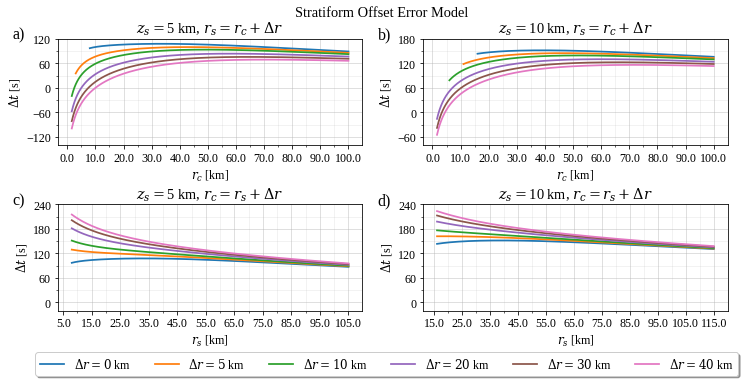

In [304]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[0], t_min=-120, t_max=120, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[1], t_min=-60, t_max=180, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[2], 
    closest='stratiform', t_max=240, r_min=5e3, r_max=105e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[3], closest='stratiform', 
    t_max=240, r_min=15e3, r_max=115e3, dr=10e3)

# lines, labels = ax[0].get_legend_handles_labels()
# lines = [lines[i] for i in [0, 3, 1, 4, 2]]
# labels = [labels[i] for i in [0, 3, 1, 4, 2]]

ax.flatten()[2].legend(
    loc='lower center',
    bbox_to_anchor=(1.08, -.67),
    ncol=6, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.56)

plt.suptitle('Stratiform Offset Error Model', y=.97)

cl.make_subplot_labels(ax.flatten(), x_shift=-.15)

plt.savefig(
    fig_dir + '/error_model.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

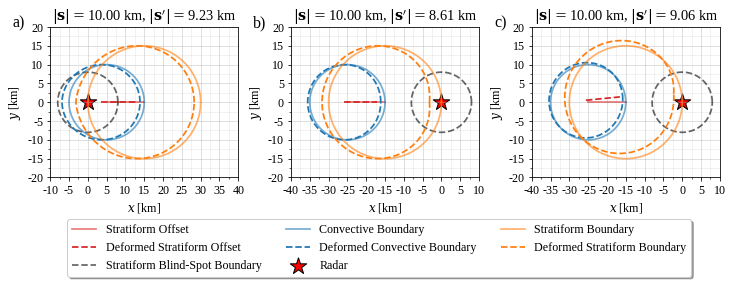

In [281]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

z_s=5e3

# row 1
bs.plot_deformation(
    fig=fig, ax=ax[0], u=-10, v=0, strat_centroid_x=15e3, 
    conv_centroid_x=5e3, 
    conv_radius=10e3, strat_radius=15e3, tau=252, 
    extent=[-10e3, 40e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[1], u=-10, v=0, strat_centroid_x=-15e3, 
    conv_centroid_x=-25e3, conv_radius=10e3, strat_radius=15e3, 
    tau=252, extent=[-40e3, 10e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[2], u=-np.sqrt(1/2)*10, v=np.sqrt(1/2)*10, 
    strat_centroid_x=-15e3, conv_centroid_x=-25e3, conv_radius=10e3, 
    strat_radius=15e3, tau=252, extent=[-40e3, 10e3, -20e3, 20e3], 
    dx=5e3, z_s=z_s)

for i in range(len(ax.flatten())):
    ax.flatten()[i].set_aspect('equal')
    
lines, labels = ax[0].get_legend_handles_labels()
lines = [lines[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]
labels = [labels[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]

ax[0].legend(
    lines, labels,
    loc='lower center',
    bbox_to_anchor=(1.75, -.7),
    ncol=3, fancybox=True, shadow=True)

cl.make_subplot_labels(ax.flatten(), x_shift=-.2)
plt.subplots_adjust(wspace=.28)

plt.savefig(
    fig_dir + '/deformation.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [305]:
x_range = np.arange(-100e3, 101e3, 1e3)
conv_radius = 10e3
strat_radius = 15e3

so_list = [10e3, 10e3, 10e3, 30e3, 10e3, 10e3]
u_list = [-10, -10, -np.sqrt(1/2)*10, -10, -10, -10]
v_list = [0, 0, np.sqrt(1/2)*10, 0, 0, 0]
conv_centroid_y = [0, 20e3, 0, 0, 0, 0]
strat_centroid_y = [0, 20e3, 0, 0, 0, 0]
conv_radius = [10e3, 10e3, 10e3, 10e3, 20e3, 10e3]
strat_radius = [15e3, 15e3, 15e3, 15e3, 15e3, 30e3]

labels = [
    r'Baseline', r'$y$ Displacement', r'Non-Parallel',
    r'$|\mathrm{\mathbf{s}}|=$ 30 km', r'Larger Convective Area', 
    r'Larger Stratiform Area']

In [306]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

In [267]:
offsets = [np.zeros(len(x_range)) for i in range(len(so_list))]

for k in range(len(so_list)):
    for i in range(len(x_range)):
        offset = bs.plot_deformation(
            u=u_list[k], v=v_list[k], 
            strat_centroid_x=x_range[i], 
            conv_centroid_x=(x_range[i]+so_list[k]),
            conv_radius=conv_radius[k], strat_radius=strat_radius[k],
            conv_centroid_y=conv_centroid_y[k],
            strat_centroid_y=strat_centroid_y[k],
            tau=300, plot=False)
        offsets[k][i] = offset
        plt.close('all')

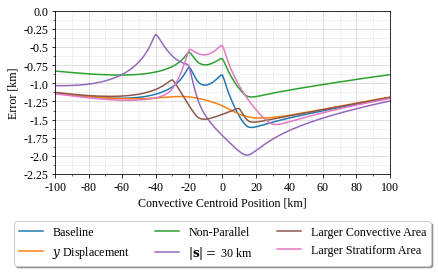

In [307]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# for so in list(set(so_list))[:-1]:
#     ax.plot(
#         x_range, so*np.ones_like(x_range),  '--', color='grey')
# ax.plot(
#     x_range, np.zeros_like(x_range),  '--', color='grey')

extent = [-100e3, 100e3, -2.25e3, 0]
dx = 20e3
dy = .25e3

for k in range(len(so_list)):

    ax.plot(
        x_range, so_list[k]-offsets[k], color=colors[k], label=labels[k])

ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
ax.set_xticks(np.arange(extent[0], extent[1]+dx, dx))
ax.set_xticks(
    np.arange(extent[0], extent[1]+dx/2, dx/2), minor=True)
ax.set_xticklabels(
    (np.arange(extent[0], extent[1]+dx, dx)/1e3).astype(int))
ax.set_yticks(np.arange(extent[2], extent[3]+dy, dy))
ax.set_yticks(
    np.arange(extent[2], extent[3]+dy/2, dy/2), minor=True)
ax.set_yticklabels(
    (np.arange(extent[2], extent[3]+dy, dy)/1e3).round(2))

ax.grid(which='minor', alpha=0.2, axis='both')
ax.grid(which='major', alpha=0.5, axis='both')
ax.set_xlabel(r'Convective Centroid Position [km]')
ax.set_ylabel(r"Error [km]")
    
ax.legend(
    loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/so_error.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [107]:
ACCESS_dicts = td.shear_versus_orientation_ACCESS()

Getting data for radar 42, year 2020.
Getting data for radar 63, year 2020.
Getting data for radar 77, year 2020.
Getting data for radar 42, year 2021.
Getting data for radar 63, year 2021.
Getting data for radar 77, year 2021.


In [108]:
radar_dicts = td.shear_versus_orientation_radar()

Getting data for radar 42, year 2020, month 10.
Getting data for radar 42, year 2020, month 11.
Getting data for radar 42, year 2020, month 12.
Getting data for radar 42, year 2021, month 1.
Getting data for radar 42, year 2021, month 2.
Getting data for radar 42, year 2021, month 3.
Getting data for radar 42, year 2021, month 4.
No systems.
Getting data for radar 63, year 2020, month 10.
Getting data for radar 63, year 2020, month 11.
Getting data for radar 63, year 2020, month 12.
Getting data for radar 63, year 2021, month 1.
Getting data for radar 63, year 2021, month 2.
Getting data for radar 63, year 2021, month 3.
Getting data for radar 63, year 2021, month 4.
Getting data for radar 77, year 2020, month 10.
Getting data for radar 77, year 2020, month 11.
Getting data for radar 77, year 2020, month 12.
Getting data for radar 77, year 2021, month 1.
Getting data for radar 77, year 2021, month 2.
Getting data for radar 77, year 2021, month 3.
Getting data for radar 77, year 2021, m

[1.0, 1.0, 1.0, 1.0]

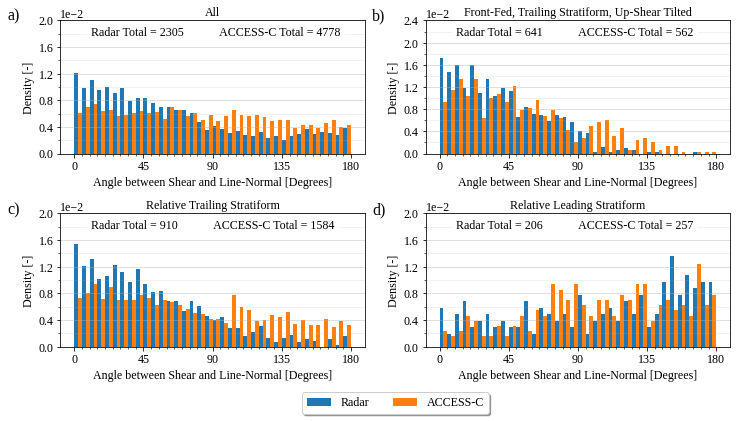

In [115]:
titles = [
    'All', 'Front-Fed, Trailing Stratiform, Up-Shear Tilted', 
    'Relative Trailing Stratiform', 'Relative Leading Stratiform']
td.shear_angle_versus_orientation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

[1.0, 1.0, 1.0, 1.0]

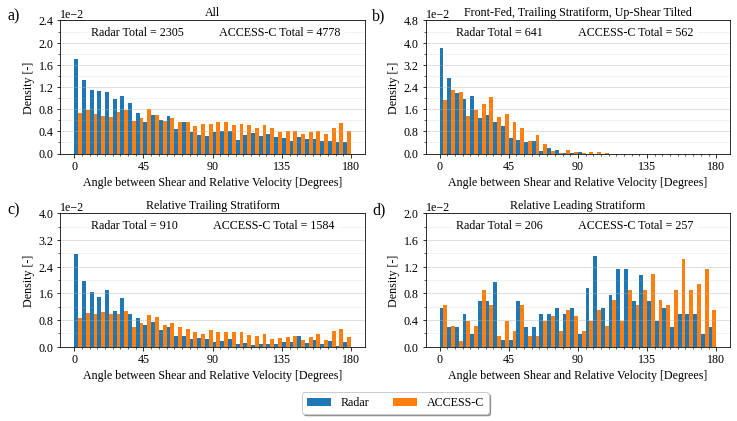

In [116]:
td.shear_angle_versus_propagation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

Radar 77, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
C

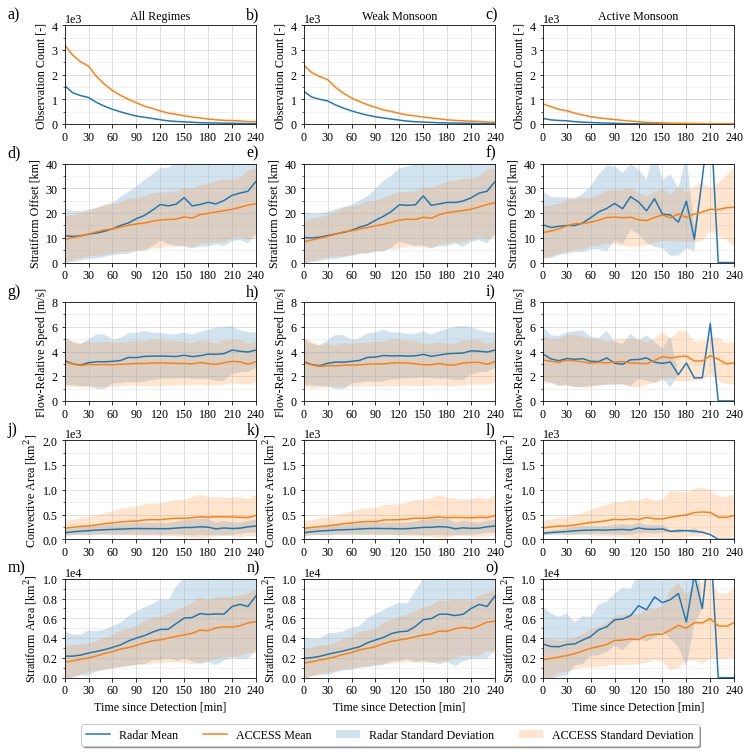

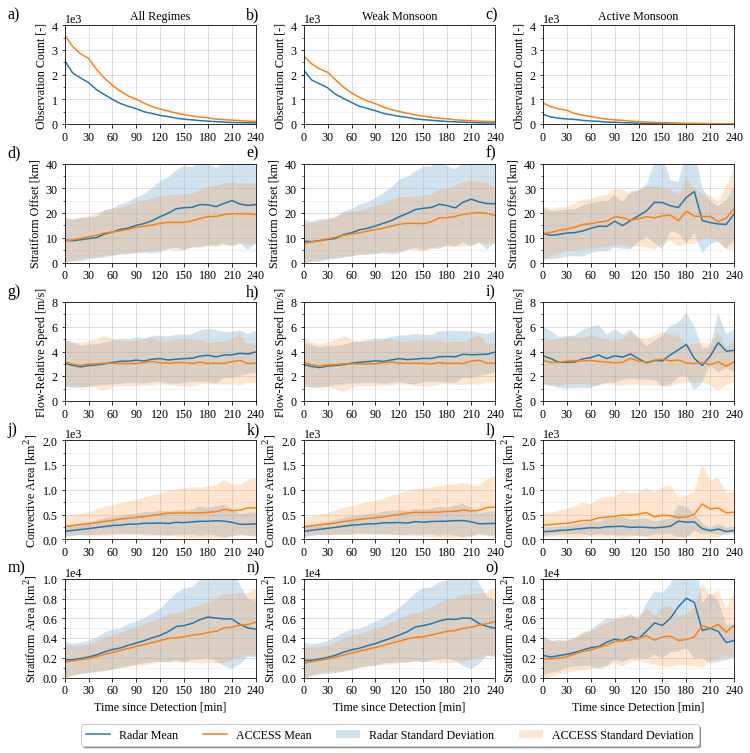

In [45]:
dsets = ['no_steiner', 'lower_ref_thresh']
for dset in dsets:
    save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_{}/'.format(dset)

    time_series_radar = bs.get_radar_prop_so_stats(
        save_dir, regime=None, radars=radars)

    time_series_weak_radar = bs.get_radar_prop_so_stats(
        save_dir, regime=1, radars=radars)

    time_series_active_radar = bs.get_radar_prop_so_stats(
        save_dir, regime=2, radars=radars)

    time_series_ACCESS = bs.get_ACCESS_prop_so_stats(
        save_dir, regime=None, radars=radars)

    time_series_weak_ACCESS = bs.get_ACCESS_prop_so_stats(
        save_dir, regime=1, radars=radars)

    time_series_active_ACCESS = bs.get_ACCESS_prop_so_stats(
        save_dir, regime=2, radars=radars)

    fig, axes = plt.subplots(5, 3, figsize=(12, 12))

    cl.init_fonts()

    x = np.arange(0, 24*60+10, 10)

    radar_d_list = [
        time_series_radar, time_series_weak_radar, time_series_active_radar]
    ACCESS_d_list = [
        time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS]

    y_lims = [(0, 4000), (0, 40), (0, 8), (0, 2000), (0, 10000)]
    dy = [1000, 10, 2, 500, 2000]
    # y_labels = [
    #     r'$|\mathrm{\mathbf{s}}|$ [km]', 
    #     r'$|\mathrm{\mathbf{v}}_r|$ [m/s]',
    #     r'Convective Area [km$^2$]']
    y_labels = [
        r'Observation Count [-]',
        r'Stratiform Offset [km]', 
        r'Flow-Relative Speed [m/s]',
        r'Convective Area [km$^2$]',
        r'Stratiform Area [km$^2$]']

    for k in range(axes.shape[1]):
        j=0
        axes[j,k].plot(x, radar_d_list[k][0], '', label='Radar Count')

        axes[j,k].plot(x, ACCESS_d_list[k][0], label='ACCESS Mean')

        y_lim = y_lims[j]

        axes[j,k].set_xlim([0, 240])
        axes[j,k].set_xticks(np.arange(0, 270, 30))
        axes[j,k].set_yticks(
            np.arange(y_lim[0], y_lim[1]+dy[j], dy[j]))
        axes[j,k].set_yticks(
            np.arange(y_lim[0], y_lim[1]+int(dy[j]/2), int(dy[j]/2)),
            minor=True)

        axes[j,k].set_ylim(y_lim)
        axes[j,k].set_ylabel(y_labels[j])
        axes[j,k].grid(which='major', alpha=0.5, axis='both')
        axes[j,k].grid(which='minor', alpha=0.2, axis='y')

        axes[j,k].ticklabel_format(
            axis='y', style='sci', scilimits=(0, 0))

    for j in range(1, axes.shape[0]):
        for k in range(axes.shape[1]):

            index = j

            radar_d = radar_d_list[k]
            ACCESS_d = ACCESS_d_list[k]

            [
                means_radar, sig_radar, means_ACCESS, sig_ACCESS] = [
                np.zeros(len(radar_d[index])) for i in range(4)]

            lens_radar = np.array(
                [len(radar_d[index][i]) for i in range(len(radar_d[index]))])
            lens_ACCESS = np.array(
                [len(ACCESS_d[index][i]) for i in range(len(ACCESS_d[index]))])

            for i in range(len(radar_d[index])):
                if lens_radar[i]>0:
                    means_radar[i] = np.nanmean(radar_d[index][i])
                    sig_radar[i] = np.sqrt(np.nanvar(radar_d[index][i]))
                if lens_ACCESS[i]>0:
                    means_ACCESS[i] = np.array(np.nanmean(ACCESS_d[index][i]))
                    sig_ACCESS[i] = np.sqrt(np.nanvar(ACCESS_d[index][i]))

            if j == 1:
                means_radar = means_radar/1000
                sig_radar = sig_radar/1000
                means_ACCESS = means_ACCESS/1000
                sig_ACCESS = sig_ACCESS/1000

            axes[j,k].plot(x, means_radar, '', label='Radar Mean')
            axes[j,k].fill_between(
                x, means_radar+sig_radar, means_radar-sig_radar, alpha=0.2,
                label='Radar Standard Deviation')

            axes[j,k].plot(x, means_ACCESS, label='ACCESS Mean')
            axes[j,k].fill_between(
                x, means_ACCESS+sig_ACCESS, means_ACCESS-sig_ACCESS, alpha=0.2,
                label='ACCESS Standard Deviation')

            y_lim = y_lims[j]

            axes[j,k].set_xlim([0, 240])
            axes[j,k].set_xticks(np.arange(0, 270, 30))
            axes[j,k].set_yticks(
                np.arange(y_lim[0], y_lim[1]+dy[j], dy[j]))
            axes[j,k].set_yticks(
                np.arange(y_lim[0], y_lim[1]+int(dy[j]/2), int(dy[j]/2)),
                minor=True)

            axes[j,k].set_ylim(y_lim)
            axes[j,k].set_ylabel(y_labels[j])
            axes[j,k].grid(which='major', alpha=0.5, axis='both')
            axes[j,k].grid(which='minor', alpha=0.2, axis='y')


            if j == 3 or j==4:
                axes[j,k].ticklabel_format(
                    axis='y', style='sci', scilimits=(0, 0))

    for j in range(3):
        axes[4,j].set_xlabel('Time since Detection [min]')

    titles = ['All Regimes', 'Weak Monsoon', 'Active Monsoon']

    for j in range(3):
        axes[0,j].set_title(titles[j], fontsize=12)

    cl.make_subplot_labels(axes.flatten(), x_shift=-.3, y_shift=.07)
    plt.subplots_adjust(wspace=.25, hspace=.4)

    lines, labels = axes[-1, 0].get_legend_handles_labels()

    lines = [lines[i] for i in[0, 2, 1, 3]]
    labels = [labels[i] for i in [0, 2, 1, 3]]

    axes[-1,0].legend(
        loc='lower center', bbox_to_anchor=(1.7, -0.75),
        ncol=4, fancybox=True, shadow=True)

    plt.savefig(
        'time_series_{}.png'.format(dset),
        dpi=200, facecolor='w',
        edgecolor='white', bbox_inches='tight')

In [58]:
dset = 'base'

save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_{}/'.format(dset)

time_series_radar = bs.get_radar_prop_so_stats(
    save_dir, regime=None, radars=radars)

time_series_weak_radar = bs.get_radar_prop_so_stats(
    save_dir, regime=1, radars=radars)

time_series_active_radar = bs.get_radar_prop_so_stats(
    save_dir, regime=2, radars=radars)

time_series_ACCESS = bs.get_ACCESS_prop_so_stats(
    save_dir, regime=None, radars=radars)

time_series_weak_ACCESS = bs.get_ACCESS_prop_so_stats(
    save_dir, regime=1, radars=radars)

time_series_active_ACCESS = bs.get_ACCESS_prop_so_stats(
    save_dir, regime=2, radars=radars)

fig, axes = plt.subplots(5, 3, figsize=(12, 12))

cl.init_fonts()

x = np.arange(0, 24*60+10, 10)

radar_d_list = [
    time_series_radar, time_series_weak_radar, time_series_active_radar]
ACCESS_d_list = [
    time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS]

y_lims = [(0, 4000), (0, 40), (0, 8), (0, 2000), (0, 10000)]
dy = [1000, 10, 2, 500, 2000]
# y_labels = [
#     r'$|\mathrm{\mathbf{s}}|$ [km]', 
#     r'$|\mathrm{\mathbf{v}}_r|$ [m/s]',
#     r'Convective Area [km$^2$]']
y_labels = [
    r'Observation Count [-]',
    r'Stratiform Offset [km]', 
    r'Flow-Relative Speed [m/s]',
    r'Convective Area [km$^2$]',
    r'Stratiform Area [km$^2$]']

for k in range(axes.shape[1]):
    j=0
    axes[j,k].plot(x, radar_d_list[k][0], '', label='Radar Count')

    axes[j,k].plot(x, ACCESS_d_list[k][0], label='ACCESS Mean')

    y_lim = y_lims[j]

    axes[j,k].set_xlim([0, 240])
    axes[j,k].set_xticks(np.arange(0, 270, 30))
    axes[j,k].set_yticks(
        np.arange(y_lim[0], y_lim[1]+dy[j], dy[j]))
    axes[j,k].set_yticks(
        np.arange(y_lim[0], y_lim[1]+int(dy[j]/2), int(dy[j]/2)),
        minor=True)

    axes[j,k].set_ylim(y_lim)
    axes[j,k].set_ylabel(y_labels[j])
    axes[j,k].grid(which='major', alpha=0.5, axis='both')
    axes[j,k].grid(which='minor', alpha=0.2, axis='y')
    
    axes[j,k].ticklabel_format(
        axis='y', style='sci', scilimits=(0, 0))

for j in range(1, axes.shape[0]):
    for k in range(axes.shape[1]):

        index = j

        radar_d = radar_d_list[k]
        ACCESS_d = ACCESS_d_list[k]

        [
            means_radar, sig_radar, means_ACCESS, sig_ACCESS] = [
            np.zeros(len(radar_d[index])) for i in range(4)]

        lens_radar = np.array(
            [len(radar_d[index][i]) for i in range(len(radar_d[index]))])
        lens_ACCESS = np.array(
            [len(ACCESS_d[index][i]) for i in range(len(ACCESS_d[index]))])

        for i in range(len(radar_d[index])):
            if lens_radar[i]>0:
                means_radar[i] = np.nanmean(radar_d[index][i])
                sig_radar[i] = np.sqrt(np.nanvar(radar_d[index][i]))
            if lens_ACCESS[i]>0:
                means_ACCESS[i] = np.array(np.nanmean(ACCESS_d[index][i]))
                sig_ACCESS[i] = np.sqrt(np.nanvar(ACCESS_d[index][i]))

        if j == 1:
            means_radar = means_radar/1000
            sig_radar = sig_radar/1000
            means_ACCESS = means_ACCESS/1000
            sig_ACCESS = sig_ACCESS/1000

        axes[j,k].plot(x, means_radar, '', label='Radar Mean')
        axes[j,k].fill_between(
            x, means_radar+sig_radar, means_radar-sig_radar, alpha=0.2,
            label='Radar Standard Deviation')

        axes[j,k].plot(x, means_ACCESS, label='ACCESS Mean')
        axes[j,k].fill_between(
            x, means_ACCESS+sig_ACCESS, means_ACCESS-sig_ACCESS, alpha=0.2,
            label='ACCESS Standard Deviation')

        y_lim = y_lims[j]

        axes[j,k].set_xlim([0, 240])
        axes[j,k].set_xticks(np.arange(0, 270, 30))
        axes[j,k].set_yticks(
            np.arange(y_lim[0], y_lim[1]+dy[j], dy[j]))
        axes[j,k].set_yticks(
            np.arange(y_lim[0], y_lim[1]+int(dy[j]/2), int(dy[j]/2)),
            minor=True)

        axes[j,k].set_ylim(y_lim)
        axes[j,k].set_ylabel(y_labels[j])
        axes[j,k].grid(which='major', alpha=0.5, axis='both')
        axes[j,k].grid(which='minor', alpha=0.2, axis='y')


        if j == 3 or j==4:
            axes[j,k].ticklabel_format(
                axis='y', style='sci', scilimits=(0, 0))

for j in range(3):
    axes[4,j].set_xlabel('Time since Detection [min]')

titles = ['All Regimes', 'Weak Monsoon', 'Active Monsoon']

for j in range(3):
    axes[0,j].set_title(titles[j], fontsize=12)

cl.make_subplot_labels(axes.flatten(), x_shift=-.3, y_shift=.07)
plt.subplots_adjust(wspace=.25, hspace=.4)

lines, labels = axes[-1, 0].get_legend_handles_labels()

lines = [lines[i] for i in[0, 2, 1, 3]]
labels = [labels[i] for i in [0, 2, 1, 3]]

axes[-1,0].legend(
    loc='lower center', bbox_to_anchor=(1.7, -0.75),
    ncol=4, fancybox=True, shadow=True)

plt.savefig(
    'time_series_{}.png'.format(dset),
    dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

In [23]:
all_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)
all_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)

weak_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)
weak_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)

active_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)
active_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)

TypeError: count_ACCESS_exclusions() got an unexpected keyword argument 'morning_only'

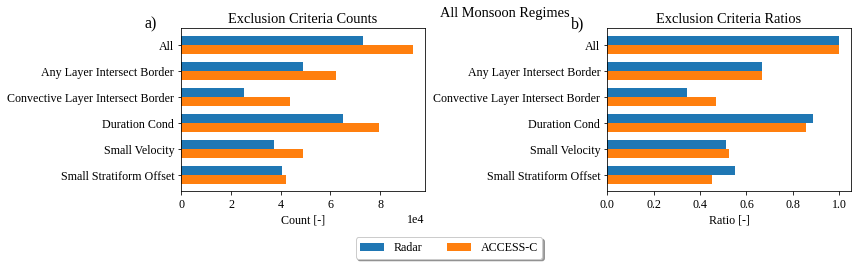

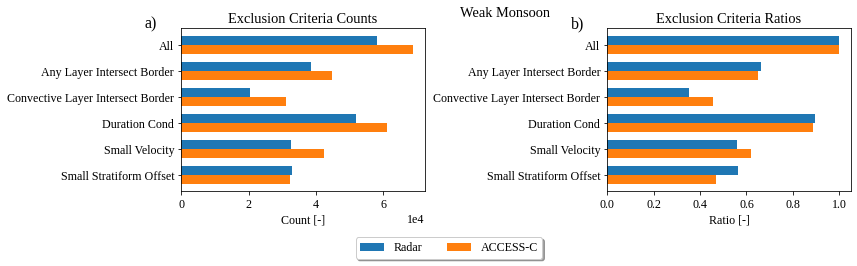

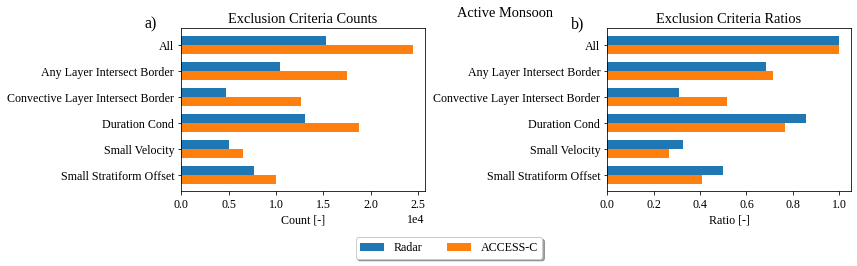

In [202]:
bs.compare_exclusions(all_excl_radar, all_excl_ACCESS, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'excl_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(weak_excl_radar, weak_excl_ACCESS, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'excl_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(active_excl_radar, active_excl_ACCESS, title='Active Monsoon')
plt.savefig(
    fig_dir + 'excl_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [2]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
file_name = '/home/student.unimelb.edu.au/shorte1/Documents/radar_examples/77_20210101.pvol/77_20210101_000500.pvol.h5'
my_radar = pyart.aux_io.read_odim_h5(file_name, file_field_names=True)

In [12]:
time = my_radar.time['data']

In [13]:
elevation =  my_radar.elevation['data']

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
t

array([  0.,  33.,  64.,  86., 106., 127., 145., 163., 180., 198., 216.,
       234., 252.], dtype=float32)

In [42]:
elevation[2000]

4.7

In [77]:
el, ind = np.unique(elevation, return_index=True)
print(el, ind)

[ 0.5  0.8  1.4  2.4  3.5  4.7  6.   7.8 10.  13.  17.  23.  32. ] [   0  360  720 1080 1440 1800 2160 2520 2880 3240 3600 3960 4320]


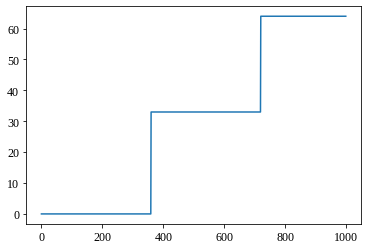

In [293]:
plt.plot(time[:1000])

In [294]:
time

array([  0.,   0.,   0., ..., 252., 252., 252.], dtype=float32)

In [291]:
el[-1]-el[-2]

9.0

In [292]:
t[-1]-t[-2]

18.0

In [232]:
# c = 62.5684116732685
c = 62.57
a = 31.5/np.sinh(252/c)
el_ap = a*np.sinh(t/c)+.5

In [288]:
a

1.1229544141076924

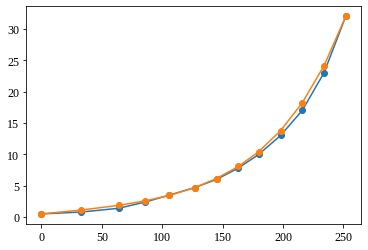

In [228]:
plt.plot(t, el, '-o')
# plt.plot(time, elevation, '-o')
# plt.plot(t, p(t))
# el_ap = np.sinh(t/61)+.5
plt.plot(t, el_ap, '-o')

In [219]:
el_ap

array([ 0.5      ,  0.8      ,  1.1998004,  1.6362213,  2.2203107,
        3.1303067,  4.2698827,  5.893951 ,  8.059732 , 11.303207 ,
       15.935074 , 22.550608 , 31.999998 ], dtype=float32)

In [224]:
el[5]

4.7

In [222]:
t[5]

127.0

In [193]:
t_ap = np.arcsinh((el-0.5))*61

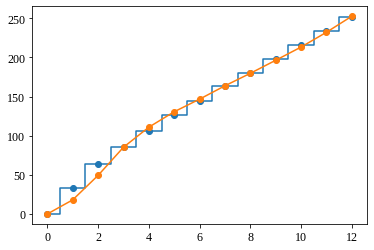

In [194]:
plt.step(t, '-o', where='mid')
plt.plot(t_ap, '-o')

In [195]:
np.max(np.abs(t[:-1]-t_ap[1:]))/252

0.09890965878236536

In [287]:
np.max(np.abs(el-el_ap))/32

0.037710726261138916

In [60]:
c = np.polyfit(t, el, 5)
# c[-1] = 0
p = np.poly1d(c)

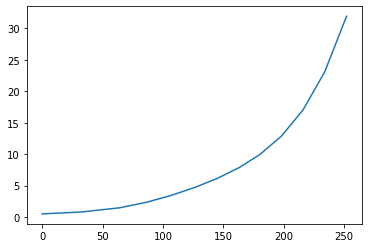

In [61]:
plt.plot(t, p(t))